In [1]:
import glob
import skimage
import skimage.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import skimage.feature as feature
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny, local_binary_pattern
import os
from skimage.filters import gabor_kernel
import time
from multiprocessing import Pool
import pickle
import pandas as pd

# HW 6 README
(this is the same as readme.txt)

Explanation of code organization:
The first section contains methods used to get features.
The next section loads pre-generated features and trains a classifier once and uses it to generate predictions for a set of images in a given folder.
The next section loads pre-generated features, since they're fairly slow to generate, and trains a classifier using cross validation. Contains code to show accuracy, important features, ect.

The final section will actually retrieve the features from the given training data. Its fairly slow. 

Explanation of features:
I broke features into three categories: color-related, shape-related, and texture-related.
Color related features are the mean of the rgb or hsv channels for the entire image, or for rgb the ratio of the mean of the 'background' versus the 'center' defined by a square region in the center of the image.
Shape features use a variety of different skimage functions that give information about keypoints, shapes, edges, and the like to generate info about the image, and reports them all relative to image size.
Texture features use two methods to get information about features that I think describe textural qualities of the image. First, it uses the histogram of oriented gratings to find information about orientations in blocks of the image. From these, it gets information about the variance, strength, and relative consistency of orientations and the like. Texture features also use the grey level co-occurence matrix properties algorithm from skimage. This describes the way that grey pixels of the same intensity co-occur at a given offsets. This is also thought to describe some textural properties.


Question answers/commentary on accuracy, important features:
My estimated mean accuracy was 33%. If you take chance to be always guessing the most commonly occuring class, airplanes, that gives about 13% accuracy. Thus, I'm a lot more accurate than random guessing.
The most important features vary slightly from fit to fit, but generally are the glcm dissimilarity, the ratio of mean green channel values in the surround vs the center, and the ratio of blue channel values in the surround vs the center.

## Feature Extraction Methods (necessary to run the final classifier)

In [2]:
#two functions that adjust the center of the image, used in getting some features.

def center_crop(image, new_width, new_height):
    """crop the image to size new_width, new_height, taking the center of the image
    Input: a color or greyscale image

    Returns: an image of size new_width, new_height
    """
    height = np.shape(image)[0]
    width = np.shape(image)[1]
    left = width/2 - new_width/2
    top = height/2 - new_height/2
    right = width/2 + new_width/2
    bottom = height/2 + new_height/2
    if len(image.shape) > 2:
        return image[int(top):int(bottom), int(left):int(right),:]
    return image[int(top):int(bottom), int(left):int(right)]

def set_center_zero(image, new_width, new_height):
    """set the center of the image, as defined by new_width, new_height, to 0.
    Used for finding color feature
    Input: a color or greyscale image

    Returns: an image with all values in size new_width, new_height set to 0
    """
    image = image.copy()
    height = np.shape(image)[0]
    width = np.shape(image)[1]
    left = width/2 - new_width/2
    top = height/2 - new_height/2

    right = width/2 + new_width/2
    bottom = height/2 + new_height/2
    image[int(top):int(bottom), int(left):int(right),:] = 0
    return image

In [3]:
#functions that generally use a single algorithm to get features

def get_n_circ_normed(image):
    """get the number of hough circles detected in the image, divided by the
    total size of the image. Searches at a number of different radii sizes,
    with the min and max determined by the image dimensions, and a step size
    of six. All points passing a threshold are counted as a circle.
    
    Input: A color or greyscale image
    Output: a float indicating the number of circles detected, divided by total
    pixels in the image
    """
    if len(np.shape(image)) > 2:
        image = skimage.color.rgb2grey(image)
    edges = canny(image, sigma=3)
    # detect series of radii based on size of image
    min_rad = int(min(image.shape)/10)
    max_rad = int(min(image.shape)/1.5)
    hough_radii = np.arange(min_rad, max_rad, 6)
    hough_res = hough_circle(edges, hough_radii)
    return len(np.where(np.ravel(hough_res) > .3)[0])/len(np.ravel(image))

def get_percent_pix_per_shape(im):
    """Uses the shape index function from skimage to find the percent of pixels
    that most likely belong to each of 9 different shapes. These include saddles,
    ridges, domes, spherical cups, ect. 
    The function returns a number between -1 and 1 for each pixel. Different shapes
    correspond to different ranges of numbers, with each shape corresponding to a
    range of i to i+1/8. Using this, I find the number of pixels that belong to
    each shape category, and divide by total pixels to get the percent
    
    Input: a greyscale image
    output: A list of length 9 of the percent of pixels belonging to each category
    """
    #get the shape index for each pixel
    s=feature.shape_index(im)
    s=np.ravel(s)
    feats=[]
    tot_n_pix = len(s)
    for i in range(0, 9):
        #find all the pixels belonging to this range of numbers
        n_pix_in_shape = len([k for k in s if k >= -1+2/8*i and k< -1+2/8*(i+1)])
        feats.append(n_pix_in_shape/tot_n_pix)
    return(feats)

def get_lbp_percents(im):
    """Using the local binary pattern algorithm, determine the percent of pixels in an image
    that are either edges or corners
    
    Input: a greyscale image
    Output: list of length two, the percent of pixels that are edges and corners
    """
    radius = 3
    n_points = radius*8
    w = width = radius - 1
    #based on skimage tutorials, find what numbers will correspond to each category of points
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                     list(range(i_34 - w, i_34 + w + 1)))

    lbp=local_binary_pattern(skimage.color.rgb2grey(im), n_points, radius, 'uniform')
    n_edge = len([x for item in lbp for x in item if x in edge_labels])
    n_flat = len([x for item in lbp for x in item if x in flat_labels])
    n_corner = len([x for item in lbp for x in item if x in corner_labels])
    per_edge = n_edge /(len(np.ravel(lbp)))
    per_corner = n_corner /len(np.ravel(lbp))
    return [per_edge, per_corner]

def get_rel_n_keypoints_and_avg_scale(im):
    """Using the CENSURE feature detector, find the # of keypoints in an image,
    and their means scale. Divide by total image size to provide a relative measure.
    
    Input: a greyscale image
    Output: a list of length two, the number of keypoints divided by total pixels,
    and the average scale of the keypoints divided by total pixels
    """
    c=feature.CENSURE()
    c.detect(im)
    imsz = len(np.ravel(im))
    return [np.shape(c.keypoints)[0]/imsz, np.mean(c.scales)/imsz]


def get_glcm_properties(image):
    """get the gray level co-occurence matrix properties of dissimilarity,
    correlation, and energy for an image. Compute for distance determined by
    the size of the image and angle 0.
    
    Input: a greyscale image
    Returns: a list of length 3
    """
    #the image must be converted to integers from floats for the glcm function
    dist = int(min(image.shape)/6)
    glcm = feature.greycomatrix((image*255).astype('uint32'), [dist], [0], 256, symmetric=True, normed=True)
    return [feature.greycoprops(glcm, 'dissimilarity')[0, 0], feature.greycoprops(glcm, 'correlation')[0, 0],
            feature.greycoprops(glcm, 'energy')[0, 0]]


def get_color_feats(im, do_hsv, do_cent_surround=False, cent_scale = None, ratio=False):
    """Gets color features for an image by taking the mean values of each color channel.
    If do_hsv is True, does so for the image converted to hsv colorspace.
    If do_cent_surround is True, it will calculate the mean values for the center of
    the image (as defined by cent_scale) and the background separately.
    If ratio is true, it will divide the values of the background by the center to get
    a relative expression of each colors importance in the center vs surround.
    In the rare case that a greyscale image is given, just returns 0
    
    Input: an rgb image
    Output: a 0x6 or 0x3 numpy array, depending on inputs
    """
    #if the image is greyscale, return arrays of 0
    if len(im.shape) < 3:
        if ratio or not do_cent_surround:
            return np.zeros((1,3))
        else:
            return np.zeros((1,6))
    if do_hsv:
        im = skimage.color.rgb2hsv(im)
    if do_cent_surround:
        feats = np.empty((1,6))
        cent_size = max(im.shape[0], im.shape[1])*cent_scale
        #get rgb values of background, the center is set to zero,
        #take the sum along the different axes
        #and then divide by total n pixels in background to get mean
        bgim = set_center_zero(im, cent_size, cent_size)
        n_bg_pix = len(np.ravel(im)) - cent_size*cent_size
        feats[0,0:3] = np.sum(np.sum(bgim, axis = 1), axis=0)/n_bg_pix
        #and the center
        cim = center_crop(im,cent_size, cent_size);
        feats[0,3:6] = np.mean(np.mean(cim,axis = 1), axis=0)
        if ratio:
            return feats[0,0:3]/feats[0,3:6]
        return feats
    else:
        return np.mean(np.mean(im, axis = 1), axis=0)
    
def get_advanced_hog_feats(fd, n_orientations):
    """given the output of a call to histogram of oriented gradients (hog),
    generate some summary features that describe the nature of orientations in the image.
    
    Finds the dominant orientation at each location by finding which index in the
    fourth dimension, which represents strength at different orientations, is the largest.
    Then it finds the overall dominant orientation in the image based which occurs most.
    Uses this in calculating several different measures of power of orientedness and variability
    of orientedness in the image.
    
    Input: fd the non-flattened output of the hog function, and n_orientations, the number
    of orientations used to calculate fd
    
    Output: a 0x6 numpy array consisting of: the most common dominant orientation (mco),
    the percent of locations where mco is the dominant orientation, var in dominant orientation, 
    total strength at the dominant orientation at each location, the strength of the orientation at locations
    where the dominant orientation is the mco divided by the total strength, and the variance in strength
    of orientedness.
    """
    X=np.empty((1,6))
    #the dominant orientation at each location
    dom_at_each_loc = np.ravel(np.argmax(fd, axis = 4))
    #count the number of times each orientation is the dominant orientation
    counts = np.bincount(dom_at_each_loc, minlength=n_orientations)
    #get the most common dominant orientation of the image
    X[0,0] = np.argmax(counts)
    #the percent of the image where that orientation is dominant
    X[0,1] = counts[np.argmax(counts)]/np.sum(counts)
    #the variance in the dominant orien
    X[0,2] = np.var(dom_at_each_loc)
    #the strength of the orientedness at the dominant orientation at each point
    strength_at_dom_or = np.ravel(np.max(fd, axis = 4))
    #the overall strength of the orientedness at dominant orientations
    X[0,3] = np.sum(strength_at_dom_or)
    #the ratio of strength at the overall dominant orient to the dominant orientations as a whole
    X[0, 4] = np.sum(strength_at_dom_or[np.where(dom_at_each_loc==np.argmax(counts))])/X[0,3]
    #the variance in strength of orientedness across the image
    X[0, 5] = np.var(strength_at_dom_or)
    return X


In [4]:
def get_shape_feats(im, do_downsize = False):
    """A helper function that gets the 14 features that that correspond to vaguely shape-like
    properties, like edges, circles, or keypoints.
    Grouped them together because they're the slowest, so require downsizing the image for
    speed. Also, I subtract the mean of the image in an attempt to normalize somewhat.
    Input: a greyscale image
    Returns: a 1x14 numpy array of shape features
    """
    feats = np.empty((1,14))
    #because lbp and the shape are especially slow, downsize images for them
    if do_downsize:
        if np.max(im.shape) > 250:
            while np.max(im.shape) > 250:
                im = skimage.transform.rescale(im, .5)
    subim = im - np.mean(np.ravel(im))
    feats[0,0:2] = get_lbp_percents(subim)
    feats[0,2:4] = get_rel_n_keypoints_and_avg_scale(subim) 

    feats[0,4] = get_n_circ_normed(subim) #number of circles

    feats[0, 5:14] = get_percent_pix_per_shape(subim)
    return feats

def get_texture_feats(im):
    """helper function to get features that describe the overall texture in the image.
    The call to hog is made here, with a cell size determined by the image size. I then
    retrieve the summary features and the glcm features
    I don't subtract the mean because these functions have their own normalization methods
    Input: a greyscale image
    Returns: a 1x9 numpy array of texture features
    """
    feats = np.empty((1,6+3))
    px_per_cell = (int(im.shape[0]/10), int(im.shape[1]/10))

    fd = feature.hog(im, orientations=8,
                                        pixels_per_cell=px_per_cell,
                     cells_per_block=(1, 1),
                                        visualise = False, feature_vector=False,
                    block_norm = 'L2-Hys')
    feats[0, 0:6] = get_advanced_hog_feats(fd, 8)
    feats[0,6:9] = get_glcm_properties(im)
    return feats

def get_all_color_feats(im):
    """a helper function to make several calls to the get_color_feats function to get
    3 sets of color features: the mean rgb value overall, the ratio of mean rgb in
    the surround vs the center, and the mean hsv values overall.
    Input: an rgb image
    Returns: a 1x9 np array of color features.
    """
    feats = np.empty((1,3+3+3))
    feats[0,0:3] = get_color_feats(im, do_hsv=False)
    feats[0,3:6] = get_color_feats(im, do_hsv=False, do_cent_surround=True,
                                   cent_scale=.5, ratio=True)
    feats[0,6:9] = get_color_feats(im, do_hsv=True)
    return feats
    
def get_one_row_feats(path):
    """loads the image and calls all the functions to assemble the full feature set.
    Input: path, a path to an image.
    Returns: feats, a 1x32 numpy array
    """
    feats = np.empty((1, 32))
    image = sio.imread(path)
    feats[0,0:9] = get_all_color_feats(image)
    grey = skimage.color.rgb2grey(image)
    feats[0,9:23] = get_shape_feats(grey, do_downsize=True)
    feats[0,23:32] = get_texture_feats(grey)
    return feats



# Load and run the final classifier

In [5]:
def run_final_classifier(filepath):
    """given a path to a folder containing images, generate the features
    for those images, load my final classifier, and use it to predict
    the classes. 
    Then write a csv from a pandas dataframe that gives the predicted class
    for each image.
    
    Input: filepath, a path to a folder containing image files
    """
    #load the features, labels, and names of categories
    features = np.load('final_features.npz')['features']
    labels = np.load('final_features.npz')['labels']
    #handle missing values
    features[np.where(np.isnan(features))] = 0
    clf = RandomForestClassifier(max_features = 'auto', n_estimators = 200, n_jobs = -1)
    X_tr, X_test, Y_tr, Y_test = train_test_split(features, labels,
                                              test_size = .1, shuffle=True)
    clf.fit(X_tr, Y_tr)

    #get all paths in the given folder
    paths = glob.glob(filepath+'/*')
    paths.sort()
    feats = np.empty((len(paths),14+9+9))
    for i, path in enumerate(paths):
        feats[i,:] = get_one_row_feats(path)
    feats[np.where(np.isnan(feats))] = 0
    
    predicted_classes = clf.predict(feats)
    
    #get the original class names to convert from numbers to class names
    folds = glob.glob('50_categories/*')
    folds.sort()
    categories_names = np.asarray([os.path.split(s)[1] for s in folds])
    predicted_names = categories_names[predicted_classes]
    #write to a csv file
    pd.DataFrame({'filename': [os.path.split(path)[1] for path in paths],
                 'predicted_class': predicted_names}).to_csv('validation_set_output.csv',
                                                             sep = ',')

In [6]:
run_final_classifier('/home/hayley/bounds_ay250_homework/validation_set/')

/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/feature/corner.py:373: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/feature/corner.py:373: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - 

# Train classifier using saved features

In [44]:
#load the features, labels, and names of categories
features = np.load('final_features.npz')['features']
labels = np.load('final_features.npz')['labels']
categories_names = np.load('final_features.npz')['categories_names']

#handle missing values
features[np.where(np.isnan(features))] = 0

In [4]:
def print_cv_score_summary(model, xx, yy, cv):
    """Just the helper function from class to print the results of cross-validation
    """
    scores = cross_val_score(model, xx, yy, cv=cv)
    print("mean accuracay: {:3f}, standard dev accuracy: {:3f}".format(
        np.mean(scores), np.std(scores)))
    
clf = RandomForestClassifier(max_features = 'auto', n_estimators = 200, n_jobs = -1)
print_cv_score_summary(clf,features,labels,
    cv=StratifiedKFold(15,shuffle=True,random_state=1))

[ 0.30592105  0.32343234  0.32107023  0.35016835  0.3105802   0.37457045
  0.32871972  0.37676056  0.32740214  0.32246377  0.35272727  0.34200743
  0.29056604  0.3256705   0.3463035 ]
mean: 0.333224, stdev: 0.023194


In [45]:
#create a non-cross-validated model to get feature importances and
#the confusion matrix
X_tr, X_test, Y_tr, Y_test = train_test_split(features, labels,
                                              test_size = .1, shuffle=True)
clf.fit(X_tr, Y_tr)
Y_pred = clf.predict(X_test)
print('Model accuracy on test data : ', accuracy_score(Y_test, Y_pred))

Model accuracy on test data :  0.32


In [46]:
#find the most important features
feature_names = ['global r mean', 'global g mean', 'global b mean', 'ratio r', 'ratio g', 'ratio b',
                'mean hue', 'mean sat', 'mean value', 'lbp percent edges', 'lbp percent corners',
                 'rel n keypoints', 'avg scale keypts', 'ncirc',
                    'shape index: cup', 'shape index: through', 'shape index: rut',
                 'shape index: saddle rut', 'shape index: saddle',
                 'shape index: saddle ridge', 'shape index: ridge', 'shape index: dome',
                   'shape index: cap','most common dom or', 'percent of im thats dom or',
                   'variance of dom orientations', 'sum of str at dom or', 'strength at spec dom or div y overall',
                   'variance of str at dom or', 'glcm dissim', 'glcm corr', 'glcm energy']
print('Three most important features : ',
      np.argsort(-clf.feature_importances_)[0:3],
     '\n which are : ',
      np.asarray(feature_names)[np.argsort(-clf.feature_importances_)[0:3]])
print('All features, ordered by importances, are : \n',
     np.asarray(feature_names)[np.argsort(-clf.feature_importances_)])

Three most important features :  [ 3 29  4] 
 which are :  ['ratio r' 'glcm dissim' 'ratio g']
All features, ordered by importances, are : 
 ['ratio r' 'glcm dissim' 'ratio g' 'ratio b' 'avg scale keypts'
 'percent of im thats dom or' 'mean hue' 'rel n keypoints' 'glcm energy'
 'variance of dom orientations' 'mean sat' 'lbp percent edges'
 'shape index: ridge' 'ncirc' 'lbp percent corners'
 'shape index: saddle rut' 'glcm corr' 'shape index: dome'
 'shape index: saddle' 'shape index: saddle ridge' 'global b mean'
 'sum of str at dom or' 'shape index: cup' 'global r mean'
 'shape index: through' 'variance of str at dom or'
 'strength at spec dom or div y overall' 'shape index: rut' 'mean value'
 'global g mean' 'most common dom or' 'shape index: cap']


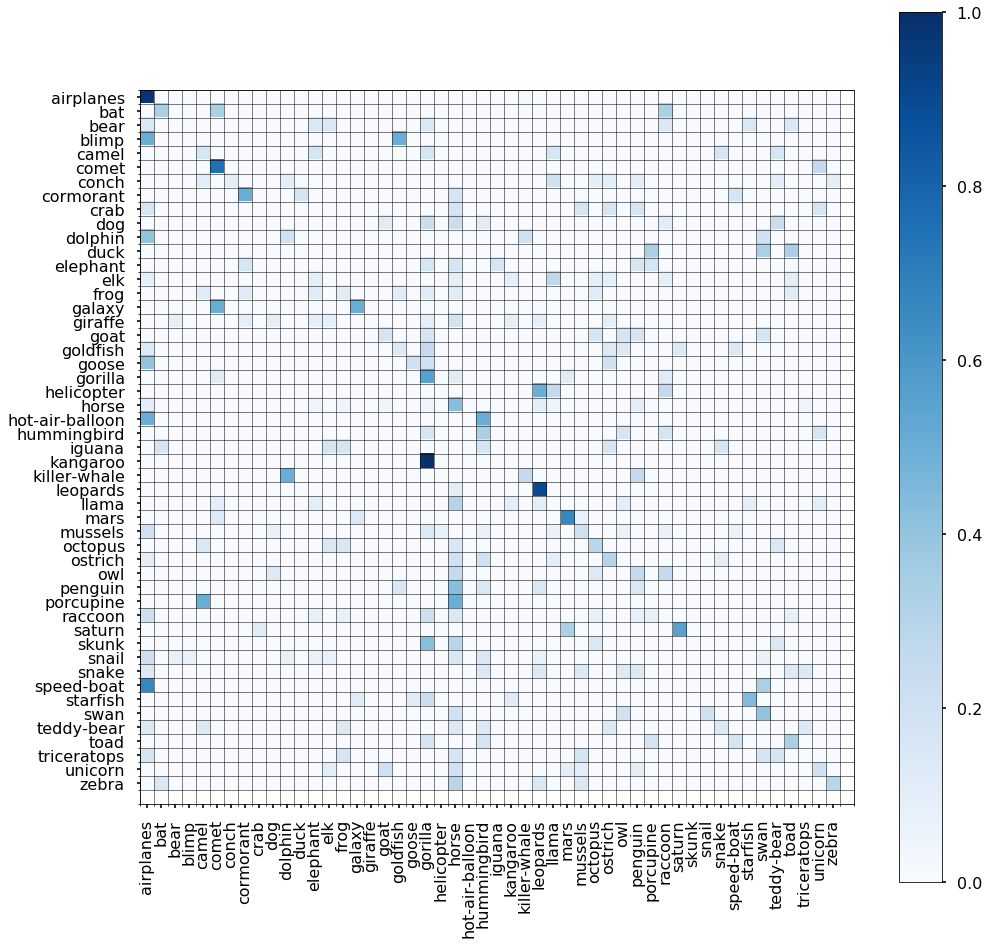

In [47]:
#plot the confusion matrix
plt.style.use('seaborn-poster')
cm = confusion_matrix(Y_test,Y_pred)
#normalize to get percents
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(0,50), categories_names[0:50], rotation = 90);
plt.yticks(range(0,50), categories_names[0:50]);


ax=plt.gca()
ax.set_xticks(np.arange(-.5, 51, 1), minor=True);
ax.set_yticks(np.arange(-.5, 51, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=.5)
plt.gcf().set_size_inches(16,16)

# Extract features from the given training data

This is fairly slow. I didn't use multiprocessing because that only made things slower on my machine, possibly because of some odd interactions with virtual box.

In [41]:
#get the names of folders and alphabetize so that it's universal across machines
folds = glob.glob('50_categories/*')
folds.sort()
#the order images of within folders doesn't matter
#get all the individual file names
ims_by_category = [glob.glob(f + '/*') for f in folds]
#unravel the file names into a single vector
paths = [path for item in ims_by_category[0:50] for path in item ]

#get the category labels
labels = []
for i in range(0,50):
    labels.append(np.repeat([i], len(ims_by_category[i])))

labels = np.concatenate(labels[0:50], axis =0 )


In [42]:
start = time.time()
feats = np.empty((len(paths),14+9+9))
for i, path in enumerate(paths):
    if i%250==0:
        print(i)
        print(time.time()-start)
    feats[i,:] = get_one_row_feats(path)

0
0.002694368362426758


/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/feature/corner.py:373: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/feature/corner.py:373: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))


250
38.24868655204773


/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


500
76.04881882667542
750
152.3123483657837
1000
224.20973539352417
1250
286.5332119464874
1500
374.2358648777008
1750
474.0577583312988
2000
553.3361575603485
2250
1658.0522067546844
2500
1740.8720467090607
2750
1812.4571981430054
3000
1899.081783771515
3250
2009.6846990585327
3500
2117.0035135746
3750
2221.3144998550415
4000
2331.457879304886


In [43]:
np.savez('final_features', features = feats, labels=labels, categories_names = categories_names)